In [7]:
import pyterrier as pt
import pandas as pd
import numpy as np
from pyterrier.measures import RR, nDCG, MAP, Recall, MRR
import nlpaug.augmenter.char as nac
import nlpaug.flow as naf

In [8]:
metrics = [RR @ 10, nDCG @ 10, MAP @ 100]
noise_levels = np.arange(0.0, 0.5, 0.1)

cer_b_1 = np.arange(0.0, 1, 0.1)
cer_b_2 = np.arange(0.0, 0.4, 0.04)


wer_b_1 = np.arange(0.0, 0.4, 0.04)
wer_b_2 = np.arange(0.0, 1, 0.1)

noise_combinations = [
    {"keyboard": 1.0},  # Keyboard noise
    {"sub": 1.0, "ins": 0.0, "del": 0.0},  # Only substitution
    # {"sub": 0.0, "ins": 1.0, "del": 0.0},  # Only insertion
    # {"sub": 0.0, "ins": 0.0, "del": 1.0},  # Only deletion
    {"sub": 0.5, "ins": 0.5, "del": 0.0},  # Substitution + Insertion
    {"sub": 0.5, "ins": 0.0, "del": 0.5},  # Substitution + Deletion
    # {"sub": 0.0, "ins": 0.5, "del": 0.5},  # Insertion + Deletion
    {"sub": 0.33, "ins": 0.33, "del": 0.33},  # Equal mix
]

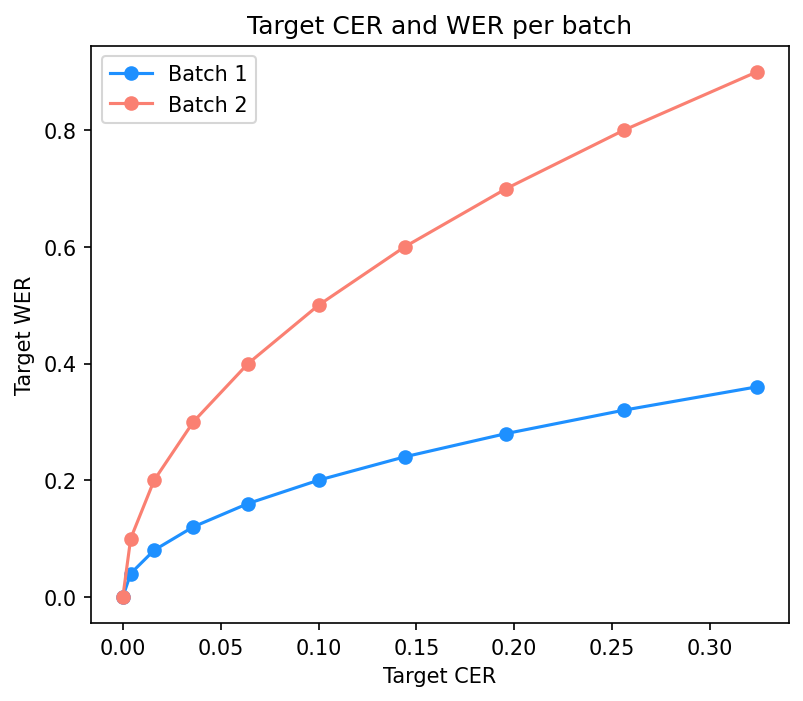

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plot
plt.figure(figsize=(6, 5), dpi=150)
plt.plot(cer_b_1*wer_b_1, wer_b_1, 'o-', label="Batch 1", color="dodgerblue")
plt.plot(cer_b_2*wer_b_2, wer_b_2, 'o-', label="Batch 2", color="salmon")
# plt.plot(cer_values, wer_values, 'o-', label="Batch 3", color="mediumseagreen")

# Labels and title
plt.xlabel("Target CER")
plt.ylabel("Target WER")
plt.title("Target CER and WER per batch")
plt.legend()

# Remove grid
plt.grid(False)

# Show plot
plt.show()


In [10]:
import Levenshtein

def calc_cer(reference: str, hypothesis: str) -> float:
    """
    Compute the Character Error Rate (CER) between a reference sentence and a hypothesis.
    
    Parameters:
        reference (str): The ground truth sentence.
        hypothesis (str): The predicted sentence.

    Returns:
        float: CER value (lower is better).
    """
    distance = Levenshtein.distance(reference, hypothesis)
    return distance / max(1, len(reference))  # Avoid division by zero

# Example usage
ref = "hello world"
hyp = "helo wrld"
print(f"CER: {calc_cer(ref, hyp):.4f}")


CER: 0.1818


In [11]:

from fast_forward.encoder import TASBEncoder
import torch

q_encoder = d_encoder = TASBEncoder(
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/262k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
dataset = pt.get_dataset("irds:beir/fiqa")

In [13]:
from pathlib import Path

indexer = pt.IterDictIndexer(
    str(Path.cwd()),  # this will be ignored
    type=pt.index.IndexingType.MEMORY,
    fields=["text"]
)
index_ref = indexer.index(dataset.get_corpus_iter())

terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started (triggered by TerrierIndexer.__init__) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
[INFO] [starting] building docstore
[INFO] [starting] opening zip file                                              
[INFO] If you have a local copy of https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/17918ed23cd04fb15047f73e6c3bd9d9
[INFO] [starting] https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip
docs_iter:   0%|                                     | 0/57638 [00:00<?, ?doc/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip: 0.0%| 0.00/17.9M [00:00<?, ?B/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip: 0.2%| 32.8k/17.9M [00:00<00:57, 310kB/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fi

In [14]:
from fast_forward.index import OnDiskIndex, Mode

ff_index_path = Path.cwd() / "07_data" / "ffindex_fiqa_tasb.h5"
ff_index_path.parent.mkdir(exist_ok=True, parents=True)
ff_index = OnDiskIndex(
    ff_index_path,
    query_encoder=q_encoder,
    mode=Mode.MAXP,
)

In [15]:
from fast_forward.util import Indexer


def docs_iter():
    for d in dataset.get_corpus_iter():
        yield {"doc_id": d["docno"], "text": d["text"]}


Indexer(ff_index, d_encoder, batch_size=8).from_dicts(docs_iter())

56737it [11:46, 79.93it/s]
56746it [11:46, 77.52it/s]█████████▊| 56737/57638 [11:46<00:11, 79.93it/s]
56760it [11:47, 71.68it/s]█████████▊| 56746/57638 [11:46<00:11, 77.51it/s]
56776it [11:47, 74.41it/s]█████████▊| 56760/57638 [11:47<00:12, 71.65it/s]
56784it [11:47, 73.15it/s]█████████▊| 56776/57638 [11:47<00:11, 74.42it/s]
56800it [11:47, 76.77it/s]█████████▊| 56784/57638 [11:47<00:11, 73.15it/s]
56808it [11:47, 72.69it/s]█████████▊| 56800/57638 [11:47<00:10, 76.77it/s]
56824it [11:48, 76.25it/s]█████████▊| 56808/57638 [11:47<00:11, 72.66it/s]
56832it [11:48, 75.00it/s]█████████▊| 56824/57638 [11:48<00:10, 76.26it/s]
56848it [11:48, 88.26it/s]█████████▊| 56832/57638 [11:48<00:10, 75.03it/s]
56857it [11:48, 81.17it/s]█████████▊| 56848/57638 [11:48<00:08, 88.28it/s]
56866it [11:48, 77.70it/s]█████████▊| 56857/57638 [11:48<00:09, 81.13it/s]
56874it [11:48, 74.05it/s]█████████▊| 56866/57638 [11:48<00:09, 77.68it/s]
56882it [11:48, 68.37it/s]█████████▊| 56874/57638 [11:48<00:10, 74.07it/s

In [16]:
from fast_forward.index import OnDiskIndex, Mode

ff_index = OnDiskIndex.load(
    Path.cwd() / "07_data" / "ffindex_fiqa_tasb.h5",
    query_encoder=q_encoder,
    mode=Mode.MAXP,
)

100%|██████████| 57638/57638 [00:00<00:00, 868013.45it/s]


In [17]:
from fast_forward.util.pyterrier import FFScore

ff_score = FFScore(ff_index)

In [18]:
bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
testset = pt.get_dataset("irds:beir/fiqa/test")
test_queries = testset.get_topics()

In [19]:
candidates = (bm25 % 5)(testset.get_topics())
candidates

[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]
[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]


09:24:20.793 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,rank,score,query
0,4641,36224,376148,0,41.677305,where should i park my rainy day emergency fund
1,4641,47916,497993,1,29.149791,where should i park my rainy day emergency fund
2,4641,55690,580025,2,26.773005,where should i park my rainy day emergency fund
3,4641,24501,253614,3,26.640181,where should i park my rainy day emergency fund
4,4641,3157,32833,4,24.265187,where should i park my rainy day emergency fund
...,...,...,...,...,...,...
3235,2399,33136,343489,0,33.280064,where do web sites get foreign exchange curren...
3236,2399,6704,69171,1,31.335596,where do web sites get foreign exchange curren...
3237,2399,4148,43046,2,31.265964,where do web sites get foreign exchange curren...
3238,2399,46670,484891,3,29.869008,where do web sites get foreign exchange curren...


In [20]:
re_ranked = ff_score(candidates)
re_ranked

,qid,docno,score,query,score_0,rank
0,9979,35369,104.525085,what is the best way to invest in gold as a he...,23.946875,0
1,9979,96351,102.627594,what is the best way to invest in gold as a he...,22.793557,1
2,9979,327271,102.549774,what is the best way to invest in gold as a he...,22.893632,2
3,9979,483734,101.910446,what is the best way to invest in gold as a he...,27.970351,3
4,9979,30584,98.504623,what is the best way to invest in gold as a he...,22.506184,4
...,...,...,...,...,...,...
3235,10034,44955,96.867386,tax implications of holding ewu or other such ...,28.036300,0
3236,10034,181942,96.055405,tax implications of holding ewu or other such ...,24.774710,1
3237,10034,180146,95.081108,tax implications of holding ewu or other such ...,23.568159,2
3238,10034,197478,94.961792,tax implications of holding ewu or other such ...,25.703399,3


In [21]:
from fast_forward.util.pyterrier import FFInterpolate

ff_int = FFInterpolate(alpha=0.5)
ff_int(re_ranked)

,qid,docno,query,score,rank
0,9979,35369,what is the best way to invest in gold as a he...,64.235980,1
1,9979,96351,what is the best way to invest in gold as a he...,62.710576,3
2,9979,327271,what is the best way to invest in gold as a he...,62.721703,2
3,9979,483734,what is the best way to invest in gold as a he...,64.940399,0
4,9979,30584,what is the best way to invest in gold as a he...,60.505403,4
...,...,...,...,...,...
3235,10034,44955,tax implications of holding ewu or other such ...,62.451843,0
3236,10034,181942,tax implications of holding ewu or other such ...,60.415057,1
3237,10034,180146,tax implications of holding ewu or other such ...,59.324633,3
3238,10034,197478,tax implications of holding ewu or other such ...,60.332595,2


In [24]:
from tqdm import tqdm
# tfidf = pt.terrier.Retriever(index_ref, wmodel="TF_IDF")

# Run Experiment
retrievers = {
    # "TF-IDF": tfidf,
    "BM25": bm25,
    "re-ranker": bm25 % 1000 >> ff_score >> ff_int,
    # "SparseColBERT": sparse_colbert,
}

results_batch_1 = []
results_batch_2 = []

for noise_config in tqdm(noise_combinations):

    if "keyboard" in noise_config:
        sub_prob = 0.0
        ins_prob = 0.0
        del_prob = 0.0
    else:    
        sub_prob = noise_config["sub"]
        ins_prob = noise_config["ins"]
        del_prob = noise_config["del"]

    # Batch 1
    results_for_augmentor_1 = []

    for model_name, retriever in retrievers.items():

        results_for_model = []

        for index in range(len(cer_b_1)):

            if "keyboard" in noise_config:
                aug = nac.KeyboardAug(aug_word_p=wer_b_1[index], aug_char_p=cer_b_1[index], include_special_char=False, aug_word_max=500000)
            else:
                aug = naf.Sequential([
                    nac.RandomCharAug(action="substitute", aug_word_p=wer_b_1[index], aug_char_p=(sub_prob * cer_b_1[index]), spec_char=""),
                    nac.RandomCharAug(action="insert", aug_word_p=wer_b_1[index], aug_char_p=(ins_prob * cer_b_1[index]), spec_char=""),
                    nac.RandomCharAug(action="delete", aug_word_p=wer_b_1[index], aug_char_p=(del_prob * cer_b_1[index]), spec_char="")
                ])

            noisy_queries_list = []

            actual_cer = 0.0

            for _, row in test_queries.iterrows():
                noisy_query = aug.augment(row['query'])
                noisy_query = " ".join(noisy_query) if isinstance(noisy_query, list) else noisy_query
                noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

                actual_cer += calc_cer(row['query'], noisy_query)

            noisy_queries_df = pd.DataFrame(noisy_queries_list)
            noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

            actual_cer = actual_cer / len(test_queries)

            eval_result = pt.Experiment(
                [retriever],
                noisy_queries_df,
                testset.get_qrels(),
                eval_metrics=[MRR @ 10, nDCG @ 10, Recall @ 10]
            )

            results_for_model.append({
                "noise_level": actual_cer,
                "results": eval_result
            })

        results_for_augmentor_1.append({
            "model_name": model_name,
            "results": results_for_model
        })

    results_batch_1.append({
        "noise_config": noise_config,
        "results": results_for_augmentor_1
    })

    # Batch 2
    results_for_augmentor_2 = []

    for model_name, retriever in retrievers.items():

        results_for_model = []

        for index in range(len(cer_b_2)):

            if "keyboard" in noise_config:
                aug = nac.KeyboardAug(aug_word_p=wer_b_2[index], aug_char_p=cer_b_2[index], include_special_char=False, aug_word_max=500000)

            else:
                aug = naf.Sequential([
                    nac.RandomCharAug(action="substitute", aug_word_p=wer_b_2[index], aug_char_p=(sub_prob * cer_b_2[index]), spec_char=""),
                    nac.RandomCharAug(action="insert", aug_word_p=wer_b_2[index], aug_char_p=(ins_prob * cer_b_2[index]), spec_char=""),
                    nac.RandomCharAug(action="delete", aug_word_p=wer_b_2[index], aug_char_p=(del_prob * cer_b_2[index]), spec_char="")
                ])

            noisy_queries_list = []

            actual_cer = 0.0

            for _, row in test_queries.iterrows():
                noisy_query = aug.augment(row['query'])
                noisy_query = " ".join(noisy_query) if isinstance(noisy_query, list) else noisy_query
                noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

                actual_cer += calc_cer(row['query'], noisy_query)

            noisy_queries_df = pd.DataFrame(noisy_queries_list)
            noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

            actual_cer = actual_cer / len(test_queries)

            eval_result = pt.Experiment(
                [retriever],
                noisy_queries_df,
                testset.get_qrels(),
                eval_metrics=[MRR @ 10, nDCG @ 10, Recall @ 10]
            )

            results_for_model.append({
                "noise_level": actual_cer,
                "results": eval_result
            })

        results_for_augmentor_2.append({
            "model_name": model_name,
            "results": results_for_model
        })

    results_batch_2.append({
        "noise_config": noise_config,
        "results": results_for_augmentor_2
    })


100%|██████████| 5/5 [1:03:39<00:00, 763.91s/it]


<ipython-input-68-b9f63ac91655>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


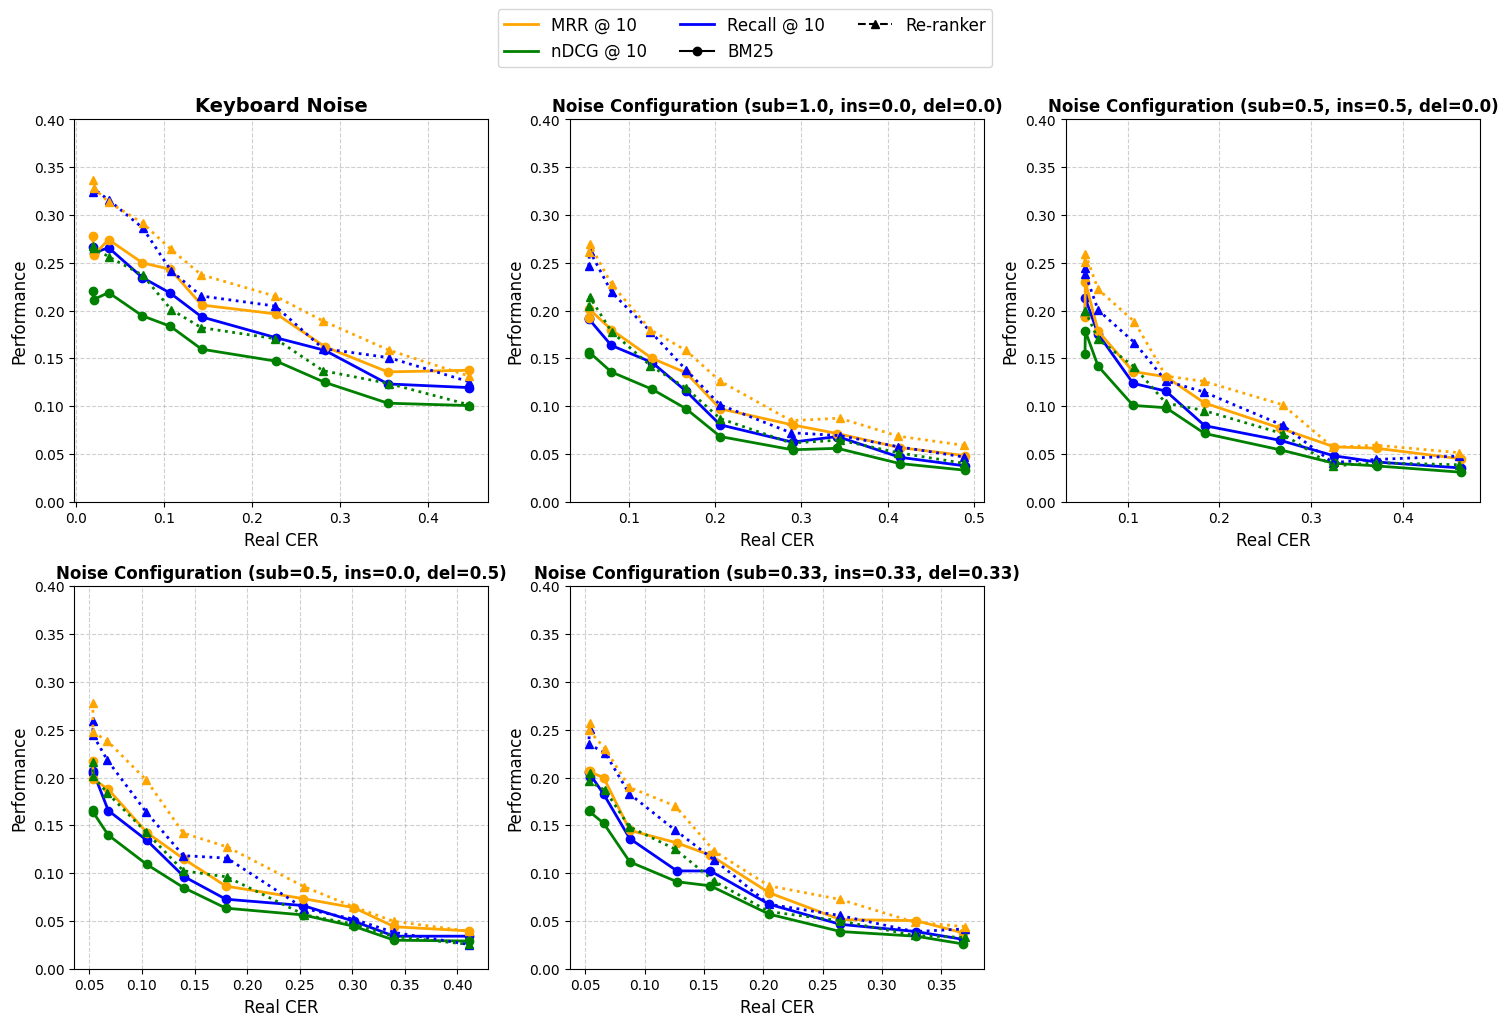

In [68]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Use a modern style
plt.style.use('seaborn-colorblind')

# Define metrics and colors for each one
metrics = ['RR@10', 'nDCG@10', 'R@10']
colors = ['b', 'g', 'orange']

# Function to format y-axis values
def format_yaxis(value, _):
    return f"{value:.2f}"

# Create a 2-row, 3-column figure for subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
axes = axes.flatten()  # Flatten to iterate easily

num_plots = min(len(results_batch_1), len(axes))

for i in range(num_plots):
    noise_config_data = results_batch_1[i]
    noise_config = noise_config_data['noise_config']
    results = noise_config_data['results']
    
    ax = axes[i]  

    for model_data in results:
        model_name = model_data['model_name']
        model_results = model_data['results']
        
        for metric_index, metric in enumerate(metrics):
            noise_levels = [result['noise_level'] for result in model_results]
            metric_values = [result['results'][metric] for result in model_results]
            
            marker = '^' if model_name == 're-ranker' else 'o'
            line_style = ':' if model_name == 're-ranker' else '-'
            
            ax.plot(noise_levels, metric_values, label=f"{model_name} - {metric}",
                    linestyle=line_style, color=colors[metric_index], marker=marker, 
                    markersize=6, linewidth=2)  # Increased marker size and line width
    
    # Set labels and title for each subplot
    ax.set_xlabel('Real CER', fontsize=12)
    ax.set_ylabel('Performance', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    
    if "keyboard" in noise_config:
        ax.set_title(f"Keyboard Noise", fontsize=14, fontweight='bold')
    else:
        ax.set_title(f"Noise Configuration (sub={noise_config['sub']}, ins={noise_config['ins']}, del={noise_config['del']})", 
                     fontsize=12, fontweight='bold')

    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_ylim(0, 0.4)
    
    ax.yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# Custom legend outside the figure
proxy_lines = [
    Line2D([0], [0], color='orange', linestyle='-', linewidth=2),
    Line2D([0], [0], color='g', linestyle='-', linewidth=2),
    Line2D([0], [0], color='b', linestyle='-', linewidth=2),
    Line2D([0], [0], color='black', marker='o', linestyle='-', markersize=6),
    Line2D([0], [0], color='black', marker='^', linestyle='--', markersize=6)
]

fig.legend(proxy_lines, ['MRR @ 10', 'nDCG @ 10', 'Recall @ 10', 'BM25', 'Re-ranker'], 
           loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3, fontsize=12, frameon=True)


# Remove unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit legend
plt.show()


<ipython-input-62-23818afbd65a>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


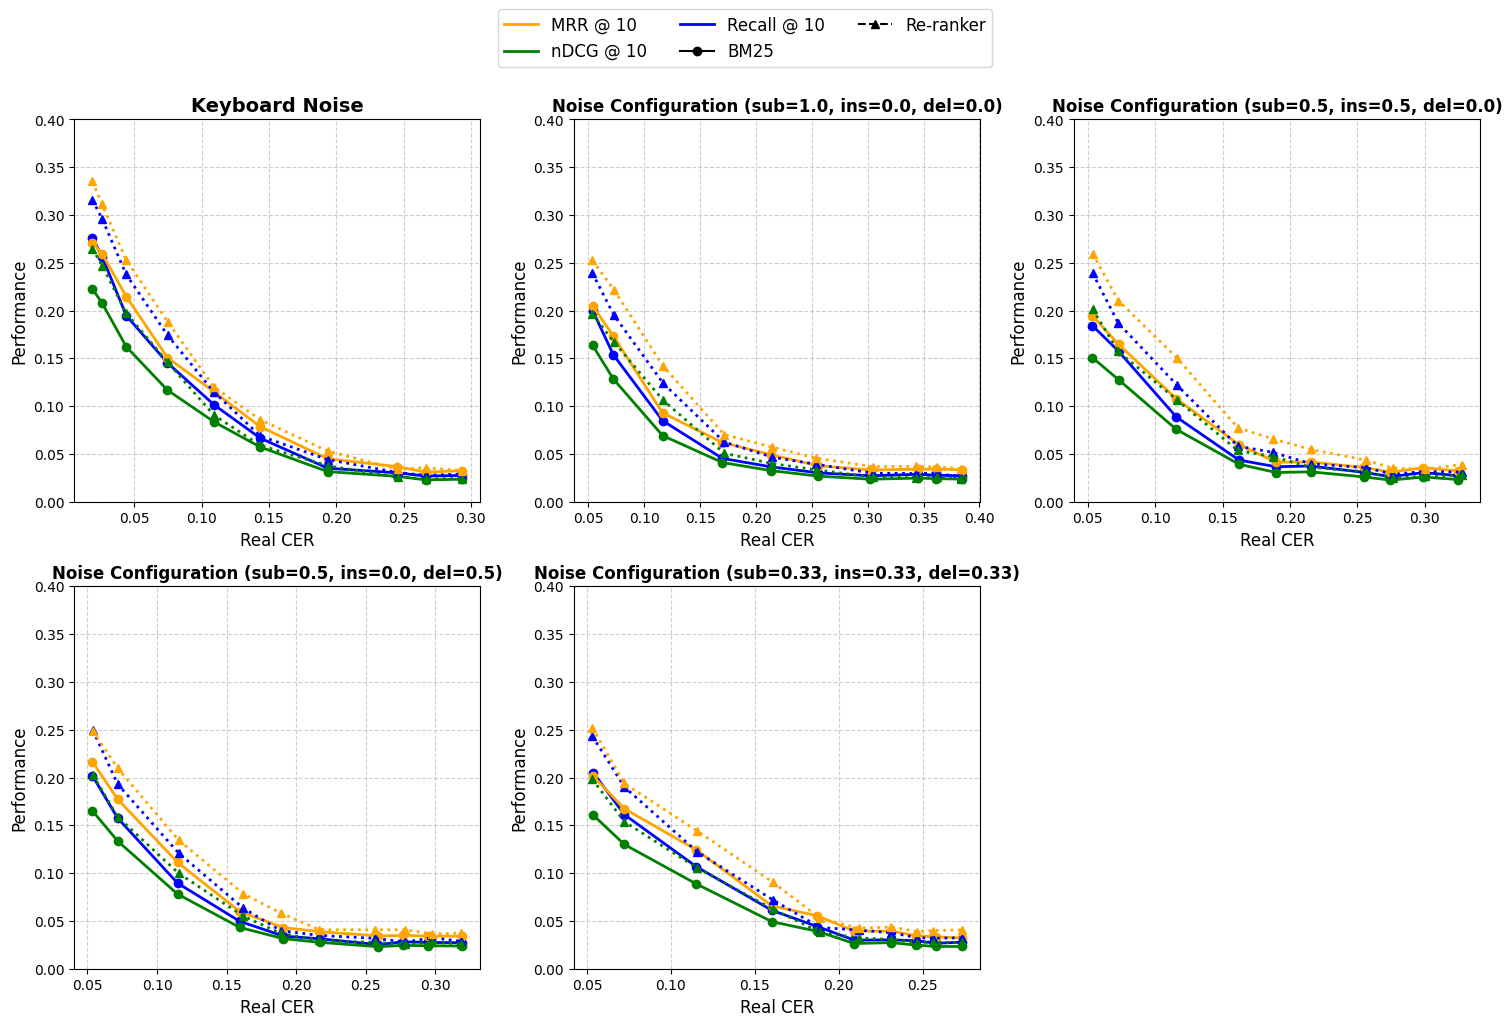

In [62]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Use a modern style
plt.style.use('seaborn-colorblind')

# Define metrics and colors for each one
metrics = ['RR@10', 'nDCG@10', 'R@10']
colors = ['b', 'g', 'orange']

# Function to format y-axis values
def format_yaxis(value, _):
    return f"{value:.2f}"

# Create a 2-row, 3-column figure for subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
axes = axes.flatten()  # Flatten to iterate easily

num_plots = min(len(results_batch_2), len(axes))

for i in range(num_plots):
    noise_config_data = results_batch_2[i]
    noise_config = noise_config_data['noise_config']
    results = noise_config_data['results']
    
    ax = axes[i]  

    for model_data in results:
        model_name = model_data['model_name']
        model_results = model_data['results']
        
        for metric_index, metric in enumerate(metrics):
            noise_levels = [result['noise_level'] for result in model_results]
            metric_values = [result['results'][metric] for result in model_results]
            
            marker = '^' if model_name == 're-ranker' else 'o'
            line_style = ':' if model_name == 're-ranker' else '-'
            
            ax.plot(noise_levels, metric_values, label=f"{model_name} - {metric}",
                    linestyle=line_style, color=colors[metric_index], marker=marker, 
                    markersize=6, linewidth=2)  # Increased marker size and line width
    
    # Set labels and title for each subplot
    ax.set_xlabel('Real CER', fontsize=12)
    ax.set_ylabel('Performance', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    
    if "keyboard" in noise_config:
        ax.set_title(f"Keyboard Noise", fontsize=14, fontweight='bold')
    else:
        ax.set_title(f"Noise Configuration (sub={noise_config['sub']}, ins={noise_config['ins']}, del={noise_config['del']})", 
                     fontsize=12, fontweight='bold')

    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_ylim(0, 0.4)
    
    ax.yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# Custom legend outside the figure
proxy_lines = [
    Line2D([0], [0], color='orange', linestyle='-', linewidth=2),
    Line2D([0], [0], color='g', linestyle='-', linewidth=2),
    Line2D([0], [0], color='b', linestyle='-', linewidth=2),
    Line2D([0], [0], color='black', marker='o', linestyle='-', markersize=6),
    Line2D([0], [0], color='black', marker='^', linestyle='--', markersize=6)
]

fig.legend(proxy_lines, ['MRR @ 10', 'nDCG @ 10', 'Recall @ 10', 'BM25', 'Re-ranker'], 
           loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3, fontsize=12, frameon=True)

# Remove unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit legend
plt.show()
